In [2]:
import sys

import pandas as pd
import numpy as np
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

from helper_funcs import eta_2_log_Gamma
from helper_funcs import log_Gamma_2_eta
from helper_funcs import eta0_2_log_delta
from helper_funcs import log_delta_2_eta0
from helper_funcs import logdotexp

# Initialize Parameters

In [3]:
# parameters for model
K = [2,5]
jump_every = 1

features = [{},
            {'diveDuration'     : {'f'           : 'normal',
                                   'lower_bound' : None,
                                   'upper_bound' : None,
                                   'share_fine'  : True,
                                   'share_coarse': False},
             'maxDepth'         : {'f'           : 'normal',
                                   'lower_bound' : np.array([-np.infty,-np.infty,-np.infty,np.log(5),np.log(5)]),
                                   'upper_bound' : np.array([np.log(20),np.log(20),np.log(20),np.infty,np.infty])},
             'avg_bot_htv'      : {'f'           : 'normal',
                                   'lower_bound' : None,
                                   'upper_bound' : None}}]#,
             #'avg_bot_abs_roll' : {'f'           : 'normal',
             #                      'lower_bound' : None,
             #                      'upper_bound' : None}}]#,
             #'postDiveInt'      : {'f'           : 'normal',
             #                      'lower_bound' : None,
             #                      'upper_bound' : None}}]#,
             #'max_bot_jp'       : {'f'           : 'normal',
             #                      'lower_bound' : None,
             #                      'upper_bound' : None}}]
             #'broadDiveType'    : {'f':'bern'}}],
             #'foraging'         : {'f':'bern'},
             #'scales'           : {'f':'bern'},
             #'click.train'      : {'f':'bern'},
             #'whales'           : {'f':'bern'}}]

# optimization parameters 
methods = ["BFGS"]#,"L-BFGS-B"]
num_epochs = 100
tol = 1e-8
grad_tol = 1e-8

# Load in Whale Data

In [4]:
df = pd.read_csv("../../dat/Final_Data_Beth.csv")

In [5]:
# load in data
df = pd.read_csv("../../dat/Final_Data_Beth.csv")

whales = pd.unique(df.ID)
df = df[df["ID"].isin(whales)]

# convert times
df["stime"] = pd.to_datetime(df["stime"])
df["etime"] = pd.to_datetime(df["etime"])

# force dives to be at least 2 seconds long
df = df[df["diveDuration"] > np.log(2.0)]

# replace -inf 
df["max_bot_jp"][df["max_bot_jp"] == -np.infty] = np.NAN

df["broadDiveType"] = np.NAN #3  # unknown
df.loc[df["maxDepth"] > np.log(20),"broadDiveType"] = 1  # deep
df.loc[df["maxDepth"] < np.log(5),"broadDiveType"] = 0  # shallow

# populate a data object

data = []

initial_ts = [0]
final_ts = []

for t,row in enumerate(df.iterrows()):
    
    if t != 0 and df.iloc[t]["ID"] != df.iloc[t-1]["ID"]:
        final_ts.append(t-1)
        initial_ts.append(t)
     
    data.append({"diveDuration"     : row[1]["diveDuration"],
                 "maxDepth"         : row[1]["maxDepth"],
                 "postDiveInt"      : np.log(max(0.5,row[1]["postDiveInt"]))})
                 #"avg_bot_htv"      : row[1]["avg_bot_htv"]})#,
                 #"avg_bot_abs_roll" : row[1]["avg_bot_abs_roll"]})
                 #"postDiveInt"      : np.log(row[1]["postDiveInt"])})
                 #"max_bot_jp"       : row[1]["max_bot_jp"]})#,
                 #"foraging"         : row[1]["foraging"],
                 #"scales"           : row[1]["scales"],
                 #"click.train"      : row[1]["click.train"],
                 #"whales"           : row[1]["whales"]})
                
final_ts.append(t)

initial_ts = np.array(initial_ts)
final_ts = np.array(final_ts)

In [6]:
#for feature in features:
#    print(feature)
#    plt.plot([datum[feature] for datum in data])
#    plt.show()

In [7]:
raw_df = pd.read_csv("../../dat/Final_rawData_Beth.csv", 
                      usecols = ["Time","p","head","pitch","roll","divenum"],
                      low_memory = True)

In [8]:
raw_df["Elevation"] = -raw_df["p"]
raw_df["Time"] = pd.to_datetime(raw_df["Time"])
raw_df = raw_df.reset_index(drop=True)

A100


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_2633/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


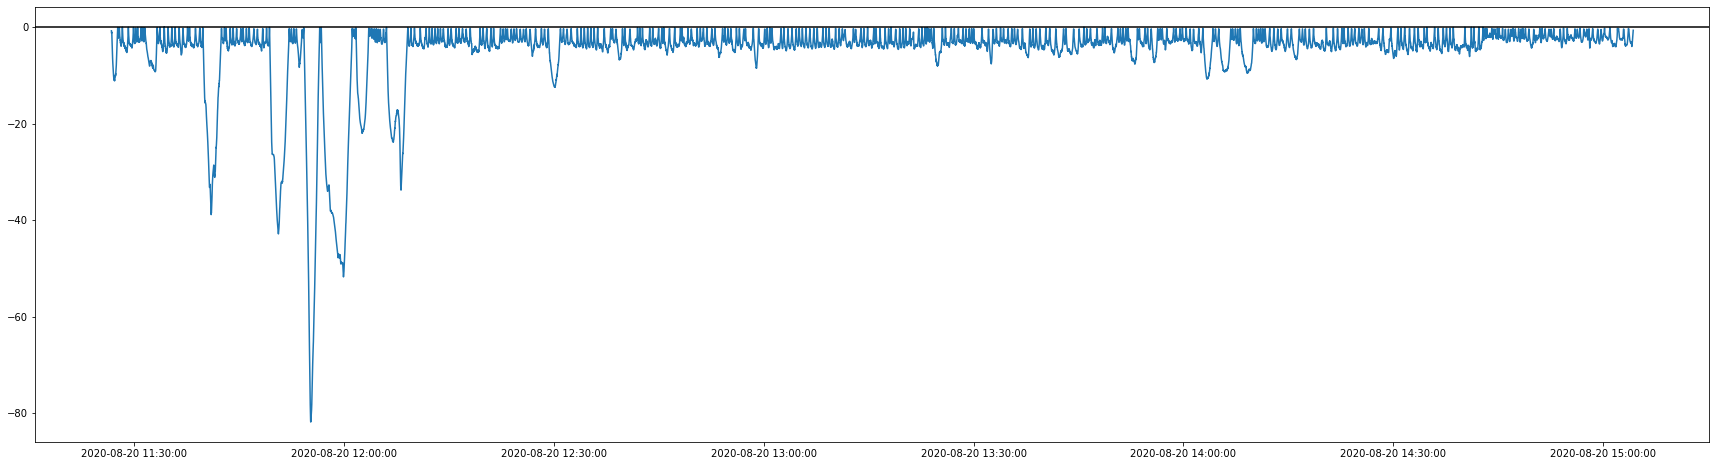

A113


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_2633/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


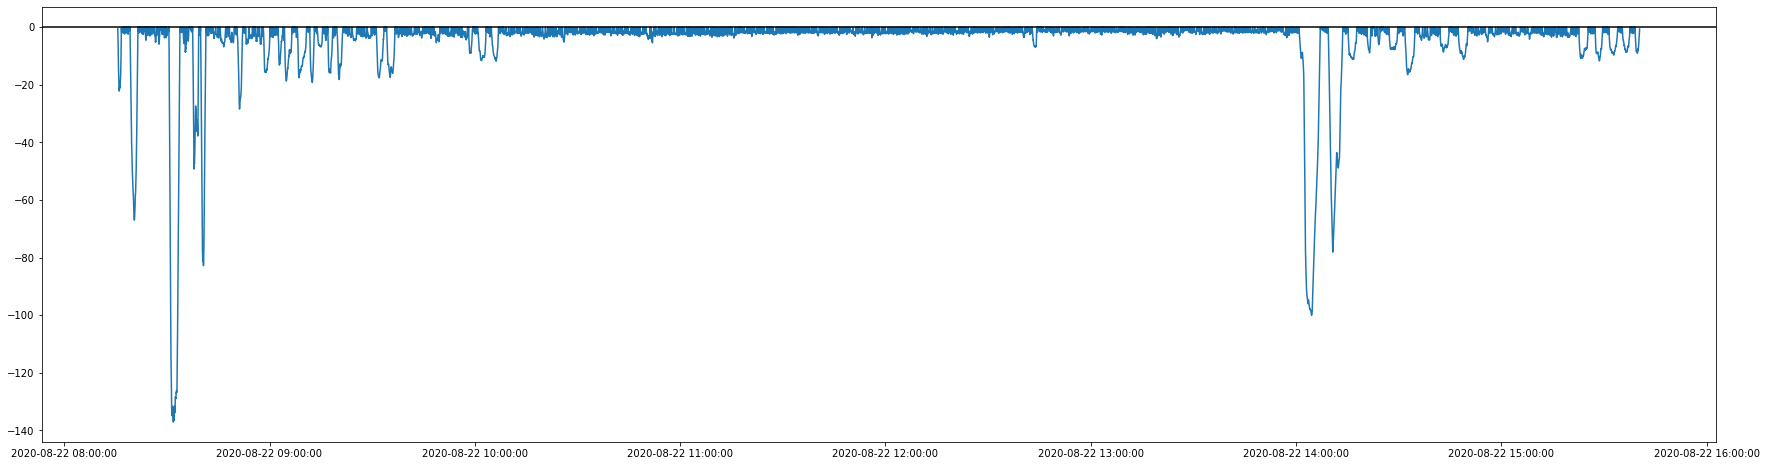

D21


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_2633/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


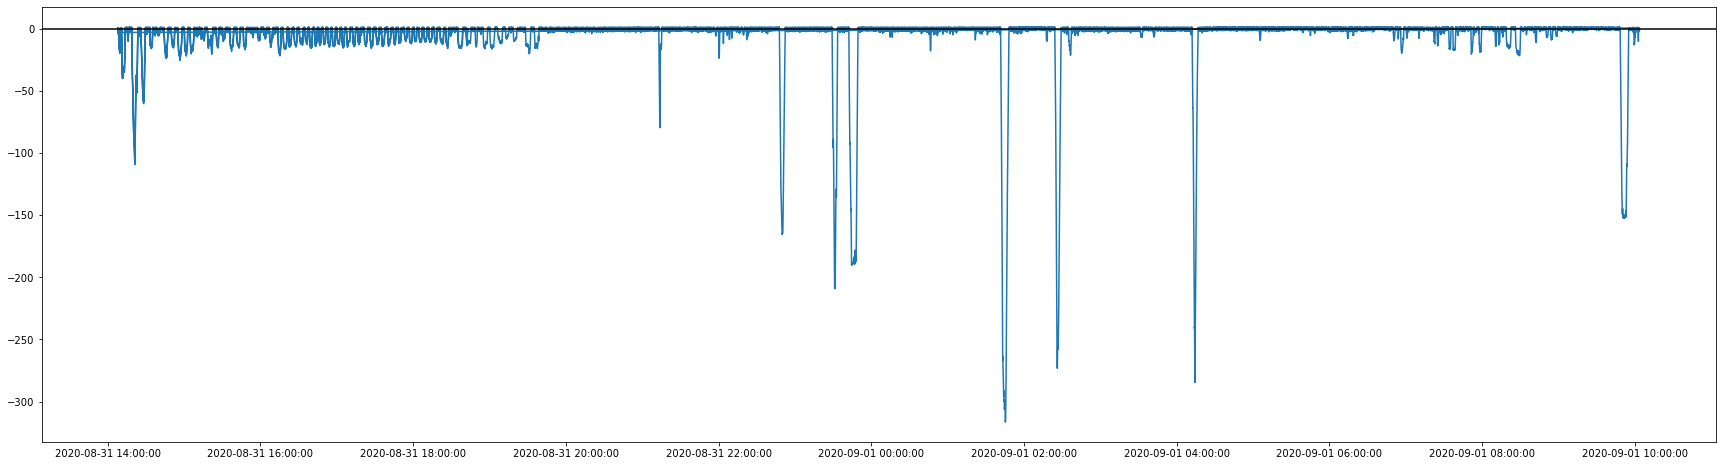

D26


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_2633/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


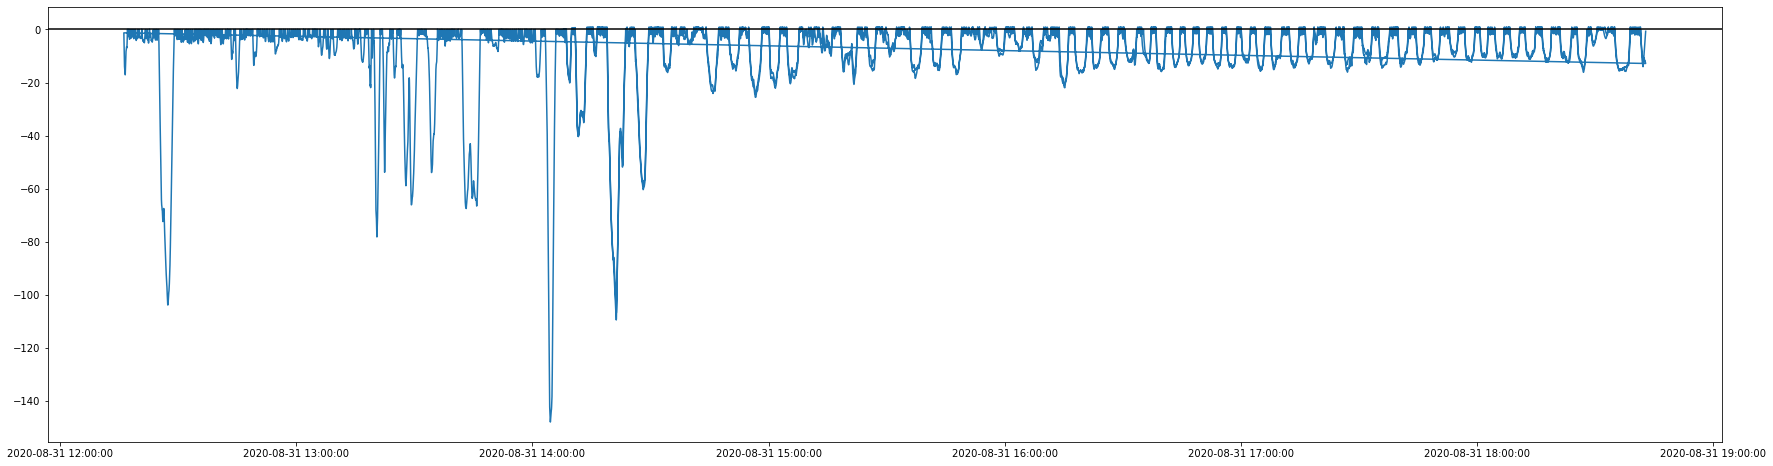

I107


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_2633/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


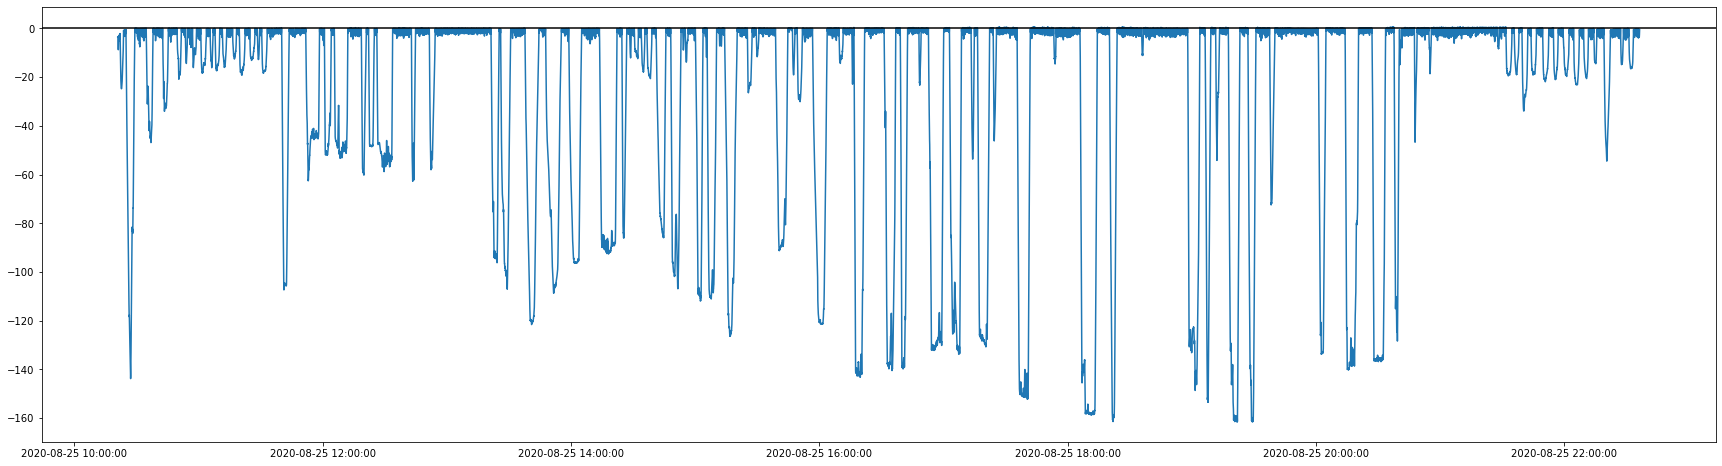

I145


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_2633/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


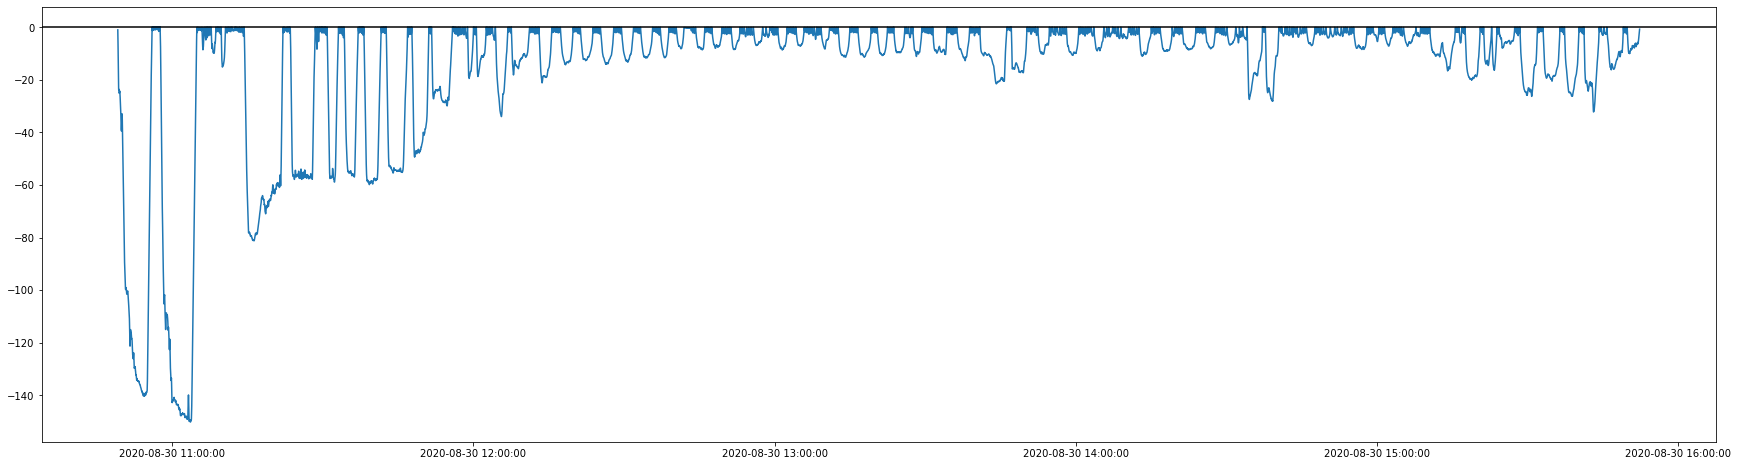

R48


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_2633/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


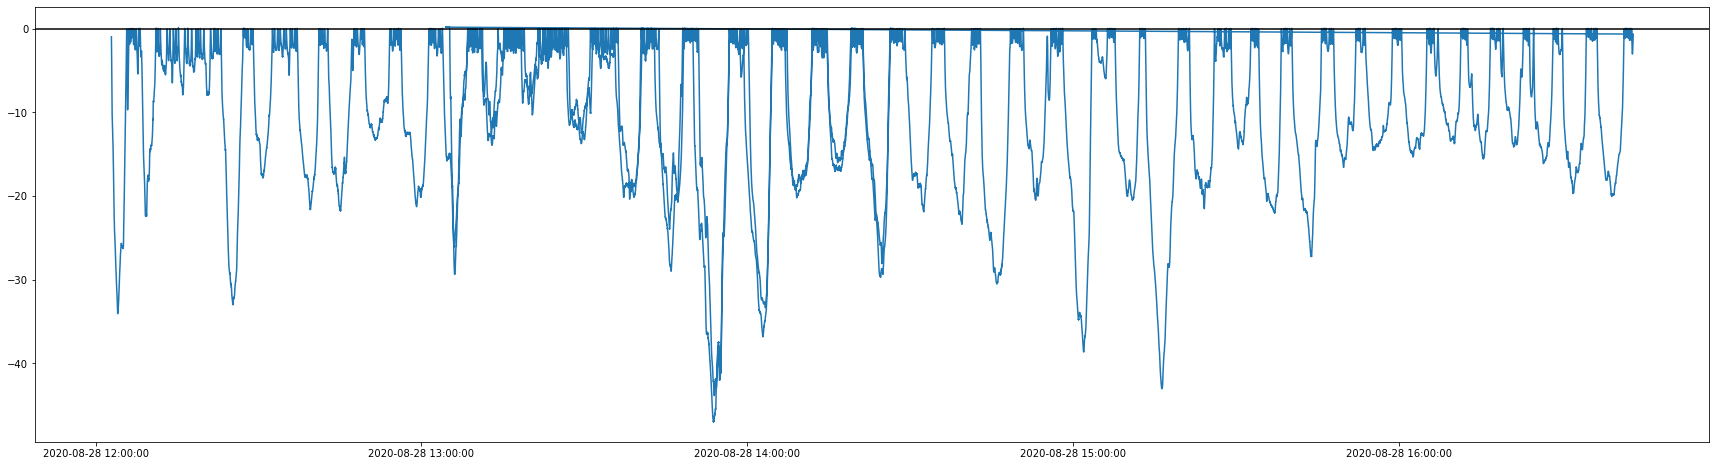

R58


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_2633/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


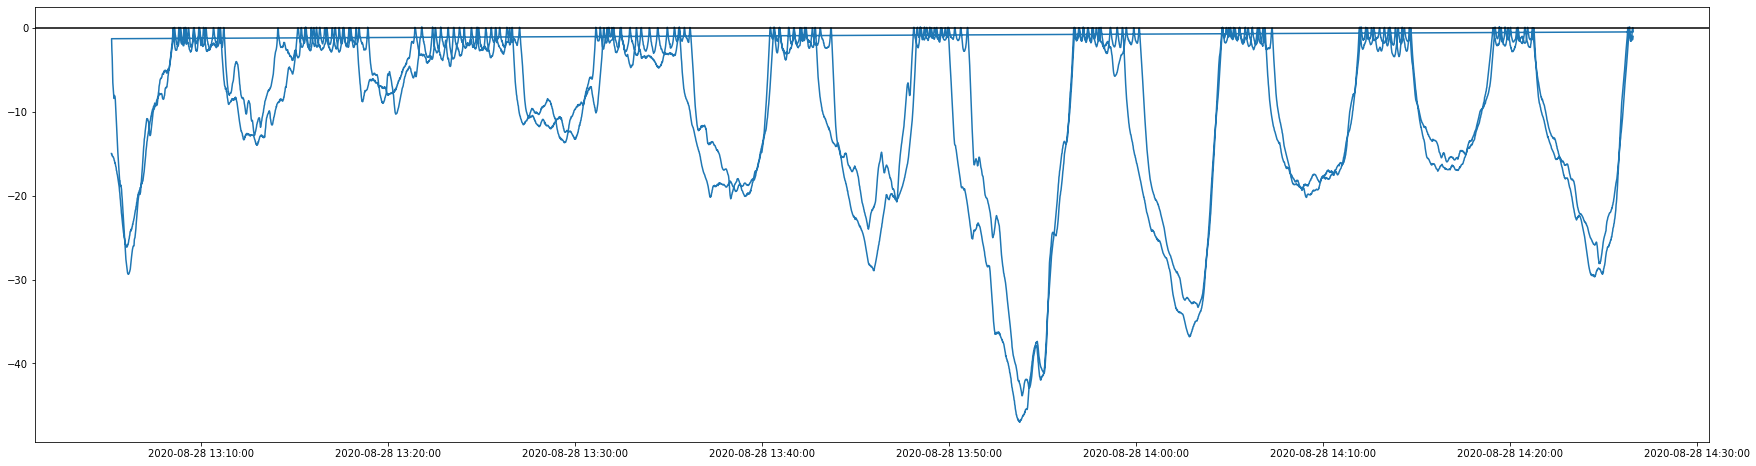

In [9]:
for whale in whales:
    print(whale)
    stime = df.loc[df["ID"].isin([whale]),"stime"].min()
    etime = df.loc[df["ID"].isin([whale]),"etime"].max()
    plt.figure(figsize=(30,8))
    plt.plot(raw_df[(raw_df["Time"] > stime) & (raw_df["Time"] < etime)].iloc[::50]["Time"],
             raw_df[(raw_df["Time"] > stime) & (raw_df["Time"] < etime)].iloc[::50]["Elevation"])
    plt.locator_params(axis='x', nbins=10)
    plt.axhline(0,color='k')
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.show()

# Train the HMM

In [10]:
date = "Sep-21-2022"

param_folder = "/Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/" + date
plot_folder = "/Users/evsi8432/Documents/Research/sublinear-HMM-inference/plt/case_study/" + date

methods = ["BFGS","SAGA","SVRG","GD","CG","control"]
K = [3,4] #K = [2,3]
partial_Es = [0,0.5,1]

In [51]:
importlib.reload(HHMM)
importlib.reload(optimizor)
importlib.reload(stoch_optimizor)

# get best ll
best_ll = -np.infty
best_optim = None

for method in methods:
    for partial_E in partial_Es:
        if method in ["BFGS","CG","GD","control"] and partial_E > 0:
            pass
        else:
            
            for rand_seed in range(100):
                
                fname = param_folder + "/case_study_Beth_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,rand_seed)
                
                try:
                    with open(fname, 'rb') as f:
                        optim = pickle.load(f)
                    #print("loaded file %s" % fname)
                except:
                    #print("file %s does not exist" % fname)
                    continue
                
                # check for some issue (likely nan in theta)
                if len(optim.time_trace) == 0:
                    #print("file %s didn't optimize." % fname)
                    continue
                    
                #print(optim.theta[0]['maxDepth']['mu'])
                #print("")
                
                if optim.log_like_trace[-1] > best_ll:
                    if optim.log_like_trace[-1] > -4.3:
                        continue
                    best_optim = optim
                    best_ll = optim.log_like_trace[-1]
                    print(fname)
            
optim = best_optim
self = optim

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/Sep-21-2022/case_study_Beth_K-3-4_BFGS_0.0_000
/Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/Sep-21-2022/case_study_Beth_K-3-4_BFGS_0.0_005
/Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/Sep-21-2022/case_study_Beth_K-3-4_BFGS_0.0_021
/Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/Sep-21-2022/case_study_Beth_K-3-4_BFGS_0.0_023
/Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/Sep-21-2022/case_study_Beth_K-3-4_BFGS_0.0_038


In [35]:
best_ll

-4.44152408503205

# Repopulate the parameters

In [36]:
self.data = data

self.log_alphas = np.zeros((self.T,self.K_total))
self.log_betas = np.zeros((self.T,self.K_total))

# p_Xt and p_Xtm1_Xt
self.p_Xt = np.zeros((self.T,self.K_total))
self.p_Xtm1_Xt = np.zeros((self.T,self.K_total,self.K_total))

# gradients wrt theta
self.grad_theta_t = [deepcopy(self.theta) for _ in range(self.T)]
self.grad_theta = deepcopy(self.theta)

# gradients wrt eta
self.grad_eta_t = [deepcopy(self.eta) for _ in range(self.T)]
self.grad_eta = deepcopy(self.eta)

# gradients wrt eta0
self.grad_eta0_t = [deepcopy(self.eta0) for _ in range(self.T)]
self.grad_eta0 = deepcopy(self.eta0)

self.E_step()
self.get_log_Gamma(jump=False)
self.get_log_Gamma(jump=True)
self.get_log_delta()

array([-2.15894208e+01, -1.56088077e+01, -2.08334555e+01, -3.06545552e+01,
       -6.97233492e+00, -1.89370040e+01, -4.53268104e-03, -5.63105605e+00,
       -3.06881132e+01, -2.05651379e+01, -3.30203868e+01, -3.40616316e+01])

# Get working Hessian

In [ ]:
self.get_working_hess()

# Get Natural Hessian

In [ ]:
self.get_natural_hess()

# Get Confidence Intervals

In [ ]:
self.get_CIs()

# Get Monte Carlo parameters

In [ ]:
self.get_monte_carlo_theta(100)

# Use Monte-Carlo estimates to get Confidence Intervals for $P(X_t|Y)$

In [ ]:
self.get_fwd_bwd_prob_CIs(0.95)

# Print Parameters

In [37]:
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[0]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][0]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][1]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][2]))

array([[7.26666469e-01, 2.67041138e-01, 6.29239313e-03],
       [2.54563308e-01, 7.44482788e-01, 9.53903981e-04],
       [3.40067855e-03, 3.46026140e-06, 9.96595861e-01]])

array([[9.99613261e-01, 2.26125207e-04, 1.52018053e-04, 8.59552061e-06],
       [1.79435548e-10, 9.99999989e-01, 3.09858776e-09, 7.73203149e-09],
       [6.89617246e-05, 9.98222841e-01, 1.68497226e-03, 2.32245709e-05],
       [9.68926035e-13, 1.00000000e+00, 1.08097344e-12, 1.40960316e-10]])

array([[1.87865561e-07, 9.99999790e-01, 2.16727995e-08, 1.61914627e-10],
       [3.23543923e-03, 9.81319435e-01, 2.31363915e-18, 1.54451254e-02],
       [3.18155421e-03, 9.96790724e-01, 2.76686992e-05, 5.30580130e-08],
       [2.22413238e-07, 9.99989451e-01, 6.54502811e-07, 9.67179934e-06]])

array([[1.11511913e-04, 9.99884572e-01, 1.25181203e-06, 2.66398478e-06],
       [7.53620804e-04, 9.76480862e-01, 2.27655110e-02, 6.69177320e-09],
       [1.00370129e-06, 9.82885931e-01, 1.71095713e-02, 3.49411684e-06],
       [9.19322974e-02, 5.42004517e-01, 7.00700713e-02, 2.95993115e-01]])

In [38]:
display(self.theta)
#display(self.theta_SE)

display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[0]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][0]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][1]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][2]))
#display(self.Gamma_SE)

display(np.exp(helper_funcs.eta0_2_log_delta(self.eta0)[0]))
display(np.exp(helper_funcs.eta0_2_log_delta(self.eta0)[1][0]))
display(np.exp(helper_funcs.eta0_2_log_delta(self.eta0)[1][1]))
display(np.exp(helper_funcs.eta0_2_log_delta(self.eta0)[1][2]))
#display(self.delta_SE)

[{'diveDuration': {'mu': array([2.15474824, 2.9399691 , 4.99855929, 4.49824727]),
   'log_sig': array([-0.74312815, -0.54520782, -0.61072308, -0.70935377])},
  'maxDepth': {'mu': array([-2.57507986,  0.69829361,  2.52193989,  2.0814295 ]),
   'log_sig': array([-0.0034128 , -0.65200724,  0.16551616, -1.09479805])},
  'postDiveInt': {'mu': array([12.1107378 ,  3.3342208 ,  2.70507227, 15.79800682]),
   'log_sig': array([ 2.72343712,  1.21401626, -0.27278484,  2.96409291])}},
 {'diveDuration': {'mu': array([2.15474824, 2.9399691 , 4.99855929, 4.49824727]),
   'log_sig': array([-0.74312815, -0.54520782, -0.61072308, -0.70935377])},
  'maxDepth': {'mu': array([-2.57507986,  0.69829361,  2.52193989,  2.0814295 ]),
   'log_sig': array([-0.0034128 , -0.65200724,  0.16551616, -1.09479805])},
  'postDiveInt': {'mu': array([12.1107378 ,  3.3342208 ,  2.70507227, 15.79800682]),
   'log_sig': array([ 2.72343712,  1.21401626, -0.27278484,  2.96409291])}},
 {'diveDuration': {'mu': array([2.15474824, 

array([[7.26666469e-01, 2.67041138e-01, 6.29239313e-03],
       [2.54563308e-01, 7.44482788e-01, 9.53903981e-04],
       [3.40067855e-03, 3.46026140e-06, 9.96595861e-01]])

array([[9.99613261e-01, 2.26125207e-04, 1.52018053e-04, 8.59552061e-06],
       [1.79435548e-10, 9.99999989e-01, 3.09858776e-09, 7.73203149e-09],
       [6.89617246e-05, 9.98222841e-01, 1.68497226e-03, 2.32245709e-05],
       [9.68926035e-13, 1.00000000e+00, 1.08097344e-12, 1.40960316e-10]])

array([[1.87865561e-07, 9.99999790e-01, 2.16727995e-08, 1.61914627e-10],
       [3.23543923e-03, 9.81319435e-01, 2.31363915e-18, 1.54451254e-02],
       [3.18155421e-03, 9.96790724e-01, 2.76686992e-05, 5.30580130e-08],
       [2.22413238e-07, 9.99989451e-01, 6.54502811e-07, 9.67179934e-06]])

array([[1.11511913e-04, 9.99884572e-01, 1.25181203e-06, 2.66398478e-06],
       [7.53620804e-04, 9.76480862e-01, 2.27655110e-02, 6.69177320e-09],
       [1.00370129e-06, 9.82885931e-01, 1.71095713e-02, 3.49411684e-06],
       [9.19322974e-02, 5.42004517e-01, 7.00700713e-02, 2.95993115e-01]])

array([1.67726855e-07, 9.99999831e-01, 1.17136920e-09])

array([2.50744301e-03, 9.92152250e-01, 5.34001705e-03, 2.89930041e-07])

array([9.37461607e-04, 5.96710563e-09, 9.95477744e-01, 3.58478823e-03])

array([4.01446793e-05, 9.99954583e-01, 3.89703604e-06, 1.37571213e-06])

In [39]:
np.linalg.eig(np.exp(eta_2_log_Gamma(self.eta)[0].T))

(array([0.4746769 , 0.99306822, 1.        ]),
 array([[ 0.71072013, -0.39355747,  0.38698284],
        [-0.70343717, -0.42276496,  0.40444714],
        [-0.00728297,  0.81632243,  0.8286536 ]]))

In [40]:
pi00 = np.linalg.eig(np.exp(eta_2_log_Gamma(self.eta)[0].T))[1][:,0]
pi00 = pi00 / sum(pi00)

pi01 = np.linalg.eig(np.exp(eta_2_log_Gamma(self.eta)[0].T))[1][:,1]
pi01 = pi01 / sum(pi01)

pi02 = np.linalg.eig(np.exp(eta_2_log_Gamma(self.eta)[0].T))[1][:,2]
pi02 = pi02 / sum(pi02)

pi10 = np.linalg.eig(np.exp(eta_2_log_Gamma(self.eta)[1][0].T))[1][:,0]
pi10 = pi10 / sum(pi10)
pi11 = np.linalg.eig(np.exp(eta_2_log_Gamma(self.eta)[1][1].T))[1][:,0]
pi11 = pi11 / sum(pi11)

display(pi00)
display(pi01)
display(pi02)

display(pi10)
display(pi11)

array([-8.19404527e+16,  8.11007837e+16,  8.39669019e+14])

array([ 4.40354103e+12,  4.73034564e+12, -9.13388667e+12])

array([0.23886597, 0.24964585, 0.51148818])

array([ 1.16751735e+12, -1.16770523e+12,  1.77848546e+08,  1.00344018e+07])

array([3.17611123e-03+0.j, 9.81661842e-01+0.j, 9.99270748e-09+0.j,
       1.51620369e-02+0.j])

# Plot emission distributions with error bounds

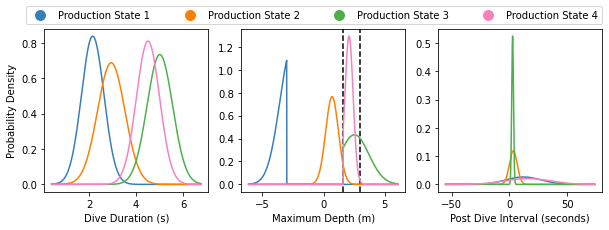

In [41]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# define colors
coarse_colors = [CB_color_cycle[i+self.K[1]] for i in range(self.K[0])]
fine_colors = [CB_color_cycle[i] for i in range(self.K[1])]

K_total = self.K[1]
perc = 0.95

fig,ax = plt.subplots(1,3,figsize=(10,3))

x_labels = {"diveDuration" : "Dive Duration (s)",
            "maxDepth"     : "Maximum Depth (m)",
            "avg_bot_htv"  : "Average Bottom RHTV (rad/s)",
            "postDiveInt"  : "Post Dive Interval (seconds)"}

for fignum,feature in enumerate(self.features):
    
    # get bounds
    min_mu = np.min([theta_fine[feature]['mu'] for theta_fine in self.theta])
    max_mu = np.max([theta_fine[feature]['mu'] for theta_fine in self.theta])
    max_sig = np.exp(np.max([theta_fine[feature]['log_sig'] for theta_fine in self.theta]))
    
    x = np.linspace(min_mu-3*max_sig,max_mu+3*max_sig,1000)
    
    # see if we are using a truncnorm
    a = self.features[feature]["lower_bound"]
    b = self.features[feature]["upper_bound"]
    if not a is None:
        a = np.concatenate([self.features[feature]["lower_bound"] for _ in self.theta])
    if not b is None:
        b = np.concatenate([self.features[feature]["upper_bound"] for _ in self.theta])

    # now get the y values for each x
    y0 = np.zeros((1000,K_total))

    # true ys
    mu = np.concatenate([theta_fine[feature]['mu'] for theta_fine in self.theta])
    sig = np.exp(np.concatenate([theta_fine[feature]['log_sig'] for theta_fine in self.theta]))

    for state in range(K_total):
        if (not a is None) and (not b is None):
            y0[:,state] = truncnorm.pdf(x,a=(a[state]-mu[state])/sig[state],
                                          b=(b[state]-mu[state])/sig[state],
                                          loc=mu[state],scale=sig[state])
        else:
            y0[:,state] = norm.pdf(x,mu[state],sig[state])
    
    if feature == "maxDepth":
        ax[fignum].axvline(np.log(20),color='k',linestyle='--')
        ax[fignum].axvline(np.log(5),color='k',linestyle='--')
    
    for state in range(self.K[1]):
        
        # plot distribution
        ax[fignum].plot(x,y0[:,state],
                        color=CB_color_cycle[state])
        
    # add labels
    if fignum == 0:
        ax[fignum].set_ylabel("Probability Density")

    ax[fignum].set_xlabel(x_labels[feature])
    #ax[fignum].set_xscale('log')
        
leg_labels = ['Production State %d'%(i+1) for i in range(self.K[1])]

legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[i],
                   markerfacecolor=fine_colors[i], markersize=12) for i in range(self.K[1])]

fig.legend(handles=legend_elements,prop={'size': 10}, ncol=self.K[1], mode="expand", borderaxespad=0.,
             bbox_to_anchor=(0.1, 0.9, 0.8, .1), loc='lower left')

#fig.tight_layout()

fig.savefig(plot_folder+'/emission_dists_K_%d_%d_nWhales_%d.png' % (self.K[0],self.K[1],len(whales)),
            dpi=300,
            bbox_inches='tight')

# Plot Dive Profiles

In [42]:
self.p_fine = np.zeros((self.T,self.K[1]))
self.p_coarse = np.zeros((self.T,self.K[0]))

# get p_coarse, p_fine, and CIs
for k0 in range(self.K[0]):
    self.p_coarse[:,k0] = np.sum(self.p_Xt[:,(k0*self.K[1]):((k0+1)*self.K[1])],1)

for k1 in range(self.K[1]):
    self.p_fine[:,k1] = np.sum(self.p_Xt[:,k1::self.K[1]],1)

In [48]:
for i in range(4):
    print(sum(self.p_fine[:,i] > 0.25))

7
5281
463
0


In [69]:
whale = "I145"
df0 = df.reset_index().drop("index",axis=1).reset_index()
ind = min(df0[df0.ID == whale]["index"])
span = len(df0[df0.ID == whale]) - 2

print(ind)
print(span)

4870
455


A100
354
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
2

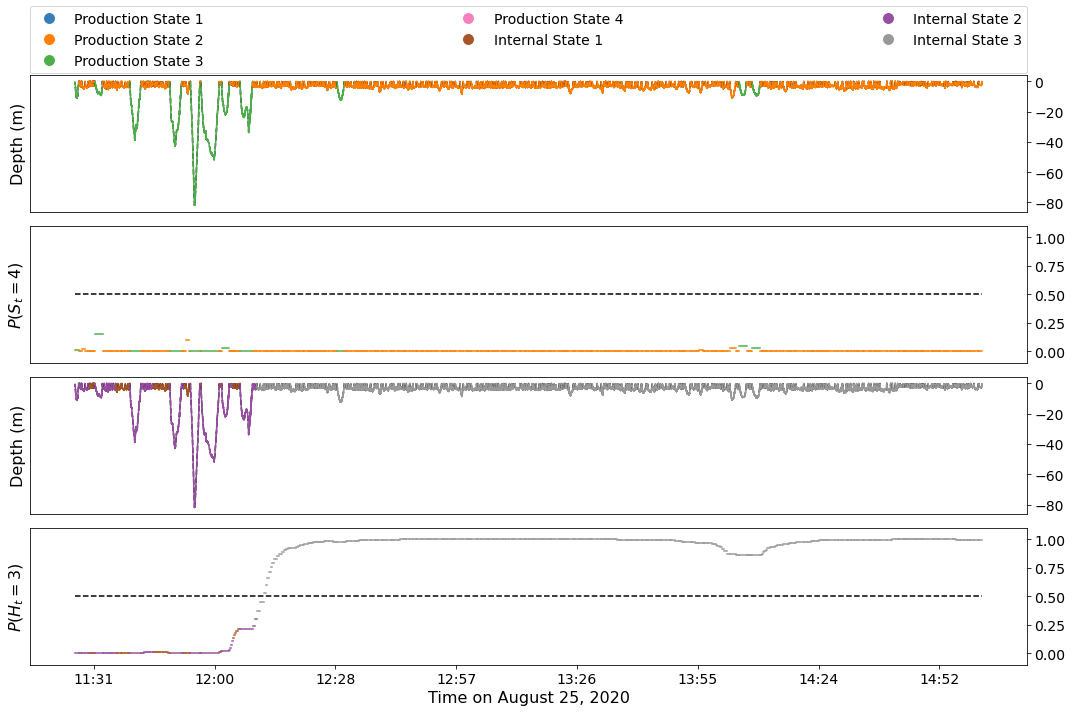

A113
858
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603

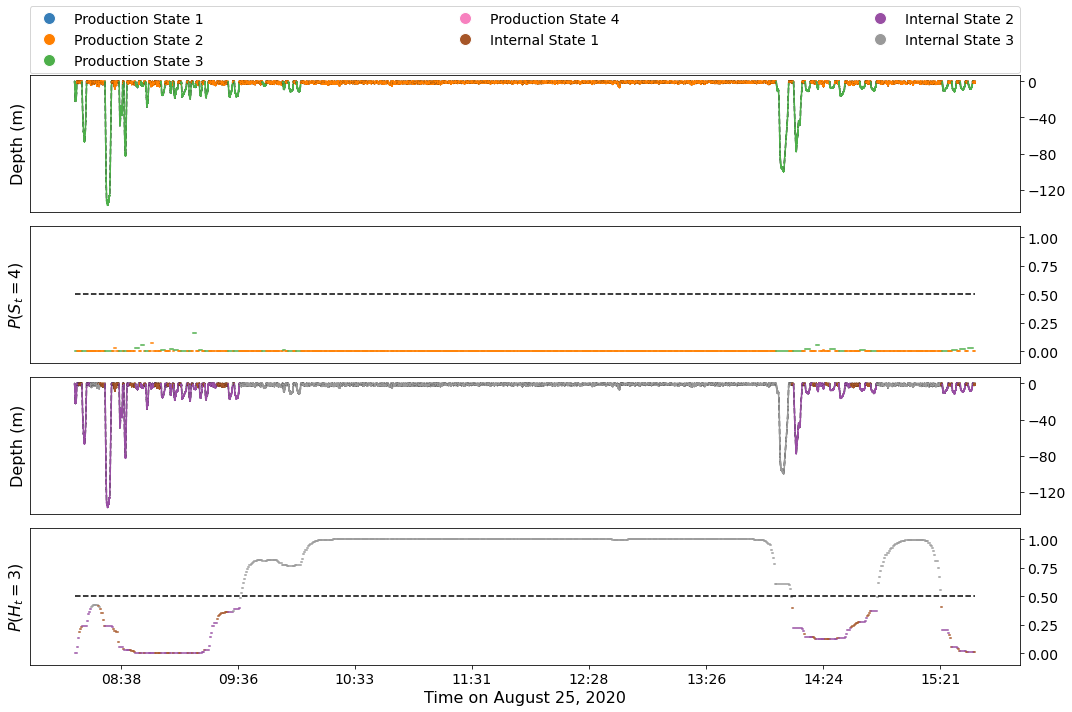

D21
1769
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1

2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984


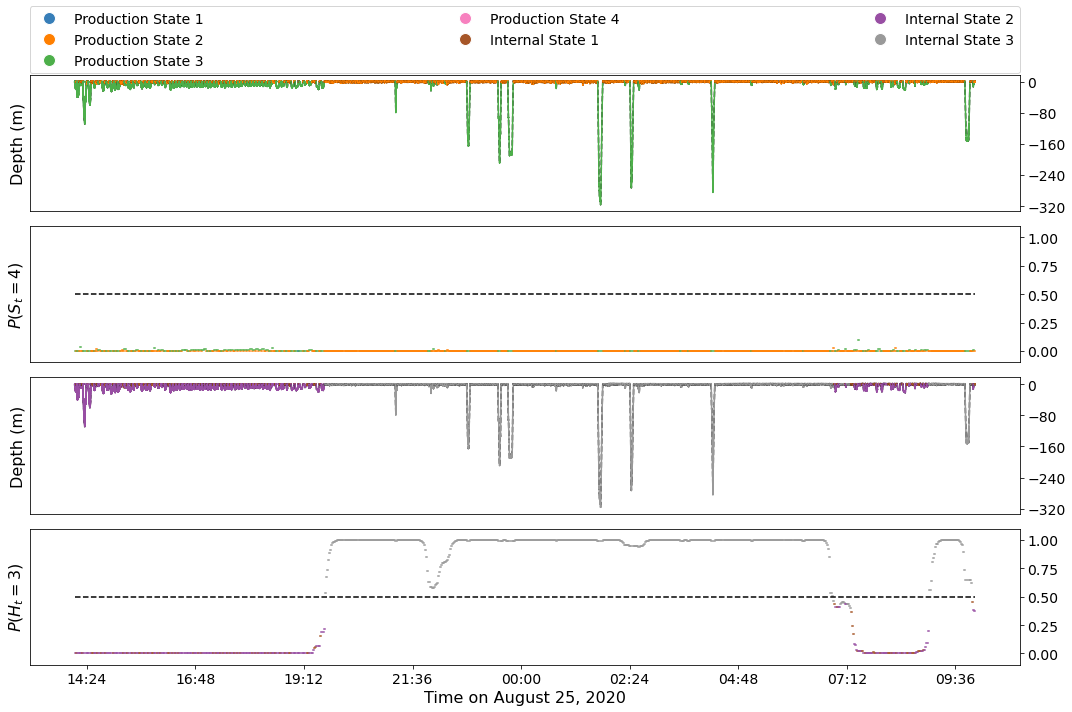

D26
572
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
31

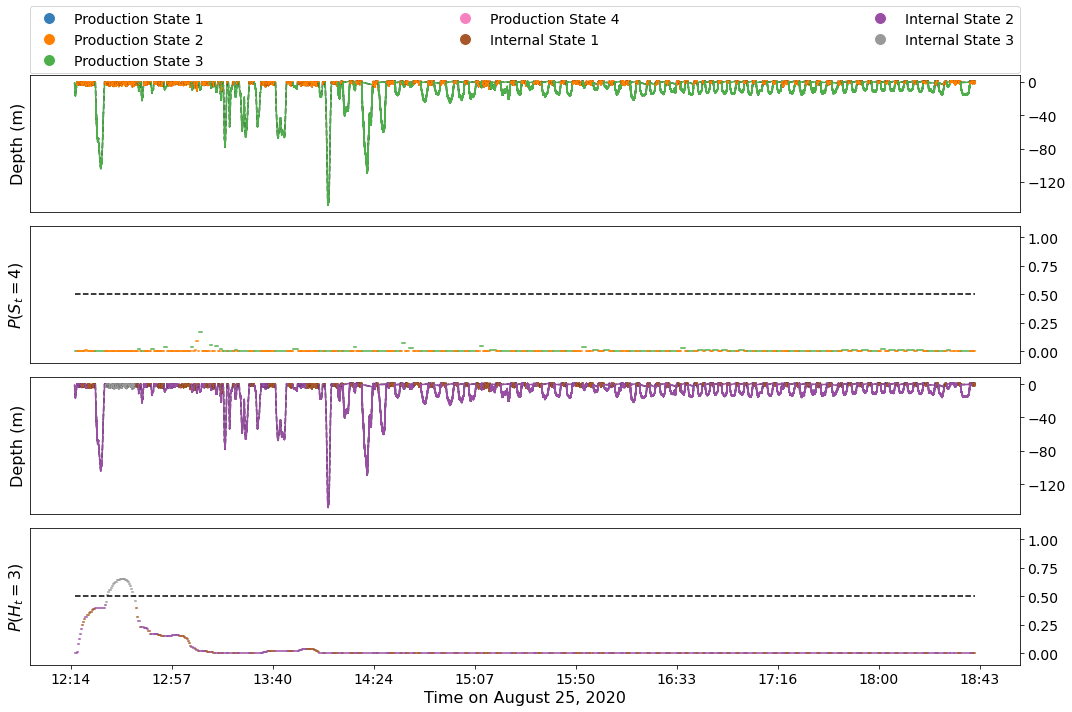

I107
1307
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758


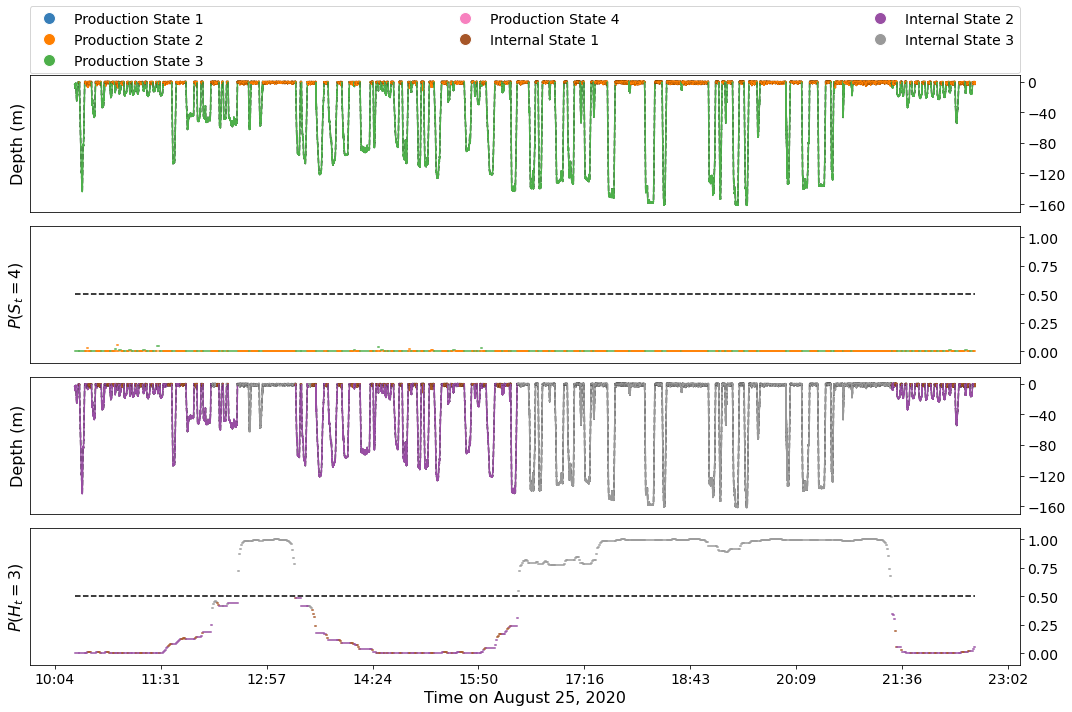

I145
455
4870
4871
4872
4873
4874
4875
4876
4877
4878
4879
4880
4881
4882
4883
4884
4885
4886
4887
4888
4889
4890
4891
4892
4893
4894
4895
4896
4897
4898
4899
4900
4901
4902
4903
4904
4905
4906
4907
4908
4909
4910
4911
4912
4913
4914
4915
4916
4917
4918
4919
4920
4921
4922
4923
4924
4925
4926
4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963
4964
4965
4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5

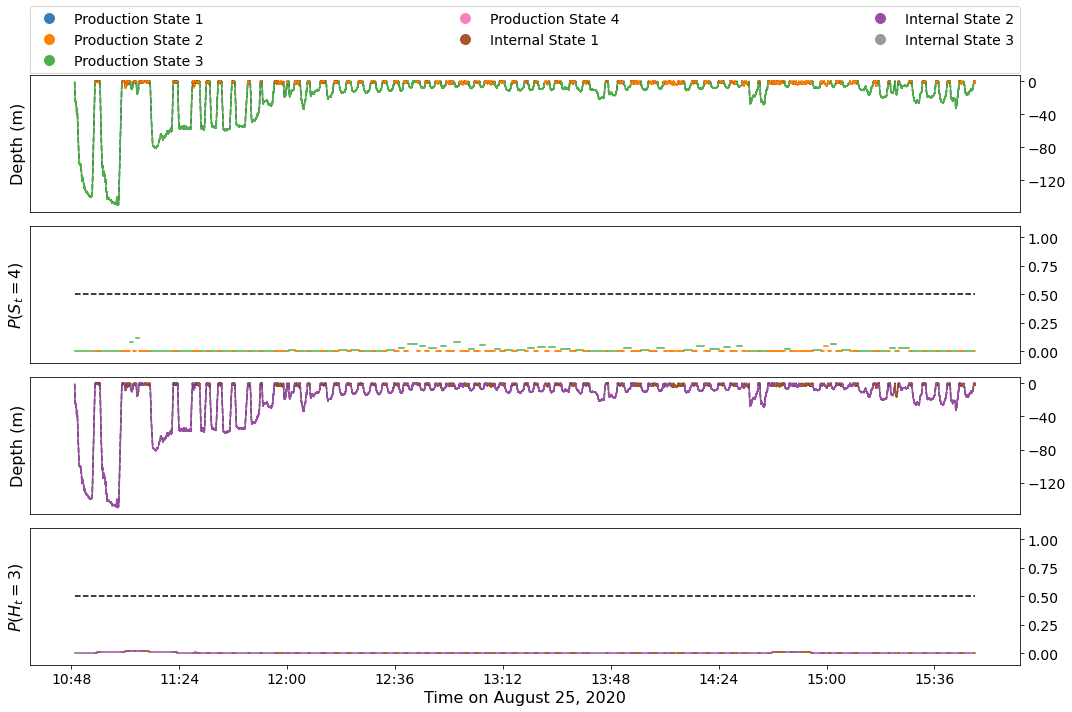

R48
305
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
55

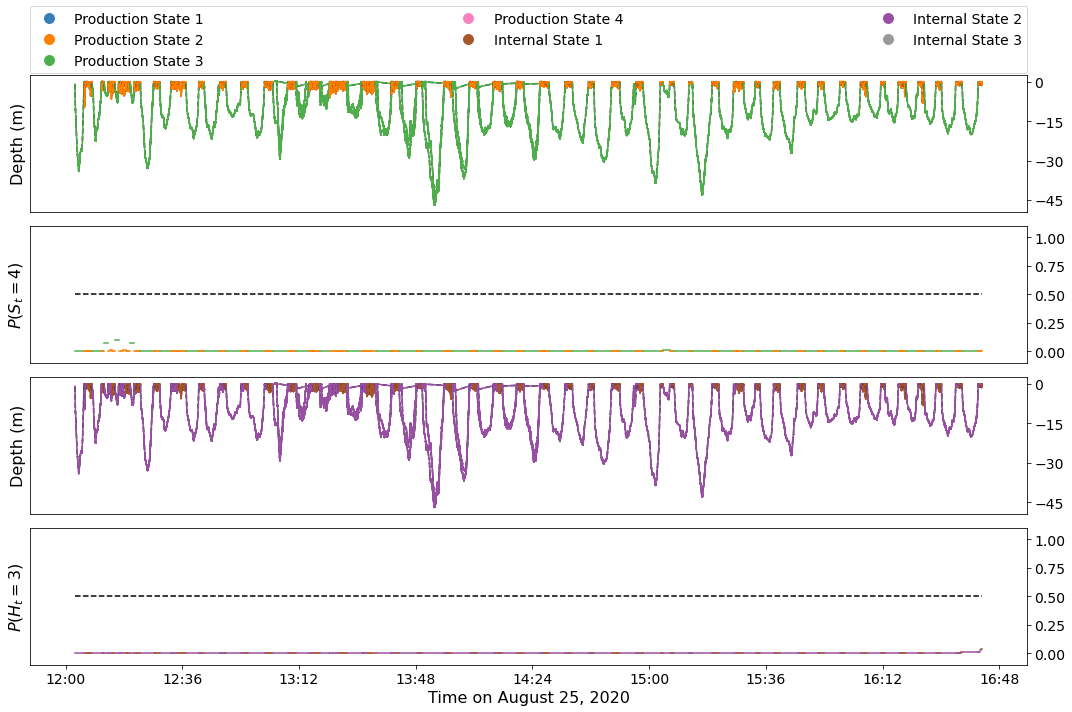

R58
92
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725


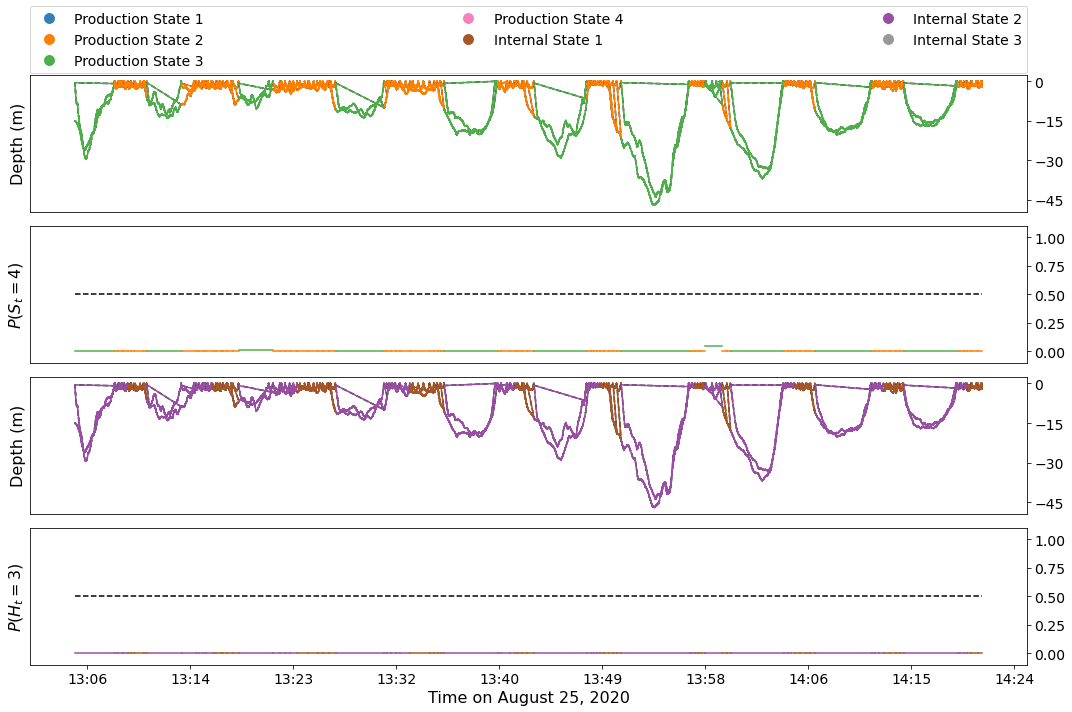

In [70]:
for whale in whales:
    
    print(whale)

    df0 = df.reset_index().drop("index",axis=1).reset_index()
    ind = min(df0[df0.ID == whale]["index"])
    span = len(df0[df0.ID == whale]) - 2
    
    print(span)

    # get the dive types
    ML_divetype = np.argmax(self.p_fine,1)
    ML_bouttype = np.argmax(self.p_coarse,1)

    # define colors
    coarse_colors = [CB_color_cycle[i+self.K[1]] for i in range(self.K[0])]
    fine_colors = [CB_color_cycle[i] for i in range(self.K[1])]

    fig,ax = plt.subplots(4,1,figsize=(15,10))

    # get legend
    labels = ['Production State 1','Production State 2','Production State 3',
              'Internal State 1','Internal State 2']
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=labels[0],
                                      markerfacecolor=fine_colors[0], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=labels[1],
                                      markerfacecolor=fine_colors[1], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=labels[2],
                                      markerfacecolor=fine_colors[2], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=labels[3],
                                      markerfacecolor=coarse_colors[0], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=labels[4],
                                      markerfacecolor=coarse_colors[1], markersize=12)]
                       #Patch(facecolor=coarse_colors[0], alpha=0.5, label=labels[4]),
                       #Patch(facecolor=coarse_colors[1], alpha=0.5, label=labels[5])]

    leg_labels = ['Production State %d'%(i+1) for i in range(self.K[1])] + \
                 ['Internal State %d'%(i+1) for i in range(self.K[0])]

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[i],
                       markerfacecolor=fine_colors[i], markersize=12) for i in range(self.K[1])] + \
                      [Line2D([0], [0], marker='o', color='w', label=leg_labels[i+self.K[1]],
                       markerfacecolor=coarse_colors[i], markersize=12) for i in range(self.K[0])]


    s_bout = df["stime"].iloc[ind]
    bouttype = ML_bouttype[ind]

    for divenum in range(ind,ind+span):

        print(divenum)

        # plot dashed line
        dive_df = raw_df[raw_df["Time"] <= df["stime"].iloc[divenum+1]]
        dive_df = dive_df[dive_df["Time"] >= df["stime"].iloc[divenum]]
        dive_df = dive_df

        # plot dive profiles
        ax[0].plot(pd.to_datetime(dive_df["Time"]),
                   dive_df["Elevation"],
                   "k--")

        ax[2].plot(pd.to_datetime(dive_df["Time"]),
                   dive_df["Elevation"],
                   "k--")

        # show color of bout / dive type
        # dive_df = raw_df[raw_df["divenum"] == df["divenum"].iloc[divenum]]

        # plot dive profiles with color
        ax[0].plot(pd.to_datetime(dive_df["Time"]),
                   dive_df["Elevation"],
                   color=fine_colors[ML_divetype[divenum]])

        ax[2].plot(pd.to_datetime(dive_df["Time"]),
                   dive_df["Elevation"],
                   color=coarse_colors[ML_bouttype[divenum]])

        # show probs of fine-scale states
        ax[1].plot(pd.to_datetime([df.iloc[divenum]["stime"],df.iloc[divenum+1]["stime"]]),
                   [self.p_fine[divenum,(self.K[1]-1)],self.p_fine[divenum,(self.K[1]-1)]],
                   color=fine_colors[ML_divetype[divenum]])

        # show probs of coarse-scale states
        ax[3].plot(pd.to_datetime([df.iloc[divenum]["stime"],df.iloc[divenum+1]["stime"]]),
                   [self.p_coarse[divenum,(self.K[0]-1)],self.p_coarse[divenum,(self.K[0]-1)]],
                    color=coarse_colors[ML_bouttype[divenum]])

    # draw lines for probabilites
    ax[3].plot([df["stime"].iloc[ind],df["stime"].iloc[ind+span]],[0.5,0.5],'k--')
    ax[1].plot([df["stime"].iloc[ind],df["stime"].iloc[ind+span]],[0.5,0.5],'k--')

    # position legend
    ax[0].legend(handles=legend_elements,prop={'size': 14}, ncol=3, mode="expand", borderaxespad=0.,
                 bbox_to_anchor=(0., 1.01, 1., .102), loc='lower left')

    for ax0 in ax:
        ax0.set_xticks([])

    ax[0].set_ylabel('Depth (m)',fontsize=16)
    ax[1].set_ylabel(r'$P(S_t = %d)$'%self.K[1],fontsize=16)

    ax[2].set_ylabel('Depth (m)',fontsize=16)
    ax[3].set_ylabel(r'$P(H_t = %d)$'%self.K[0],fontsize=16)

    ax[1].set_ylim([-0.1,1.1])
    ax[3].set_ylim([-0.1,1.1])

    ax[0].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[1].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[2].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[3].yaxis.set_major_locator(plt.MaxNLocator(5))


    ax[-1].set_xlabel("Time on August 25, 2020",fontsize=16)
    ax[-1].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[-1].xaxis.set_major_formatter(DateFormatter('%H:%M'))

    for ax0 in ax:
        ax0.yaxis.tick_right()
        for item in ax0.get_yticklabels():
            item.set_fontsize(14)
        for item in ax0.get_xticklabels():
            item.set_fontsize(14)

    plt.tight_layout()
    plt.savefig(plot_folder+'/decoded_dives_kw_%s_K_%d_%d_nWhales_%d.png'%(whale,self.K[0],self.K[1],len(whales)),dpi=300)
    plt.show()

# Plot Pseudoresiduals

In [ ]:
for feature in self.features[1]:

    print(feature)
    
    pseudoresids = self.get_pseudoresids(feature)
        
    plt.hist(pseudoresids,bins=25,density=True,alpha=0.5,color='k')
    x = np.linspace(-5,5,1000)
    plt.plot(x,norm.pdf(x),'k-')
    plt.title("Pseudoresiduals of %s" % x_labels[feature])
    plt.xlabel("Pseudoresidual")
    plt.ylabel("Density")
    plt.savefig('../plt/pseudo_hist_%s_K_%d_%d_nWhales_%d.png'%(feature,self.K[0],self.K[1],len(whales)),dpi=300)
    plt.show()
    
    plt.plot(pseudoresids,'.')
    plt.title("Pseudoresiduals of %s" % x_labels[feature])
    plt.ylabel("Pseudoresidual")
    plt.xlabel(r"t")
    plt.plot(np.zeros_like(pseudoresids),'k--')
    plt.savefig('../plt/pseudo_%s_K_%d_%d_nWhales_%d.png'%(feature,self.K[0],self.K[1],len(whales)),dpi=300)
    plt.show()
    
    sm.qqplot(np.array(pseudoresids), line='45')
    plt.title("Pseudoresidual QQ plot of %s" % x_labels[feature])
    plt.savefig('../plt/pseudo_qq_%s_K_%d_%d_nWhales_%d.png'%(feature,self.K[0],self.K[1],len(whales)),dpi=300)
    plt.show()

# Save Results